# Pattern prediction for long-term strategies

#### Packages required

In [461]:
import pandas as pd
import numpy as np
import math
import statistics as st
from datetime import timedelta
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import silhouette_score
from collections import defaultdict
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import GaussianNB

## Dataset

#### Dataset consists of the closing prices of three stock indices namely SENSEX, NIFTY50 and NIFTY Consumption

In [462]:
df = pd.read_excel("../datasets/indian_stock_indices/Stock_Indices.xlsx")

In [463]:
df.head()

,Date,SENSEX,NIFTY50,NIFTY_CONSUMPTION
0,2014-01-01,21140.48,6323.80,2590.000000
1,2014-01-02,20888.33,6301.25,2544.649902
2,2014-01-03,20851.33,6194.55,2546.949951
3,2014-01-06,20787.30,6220.85,2544.649902
4,2014-01-07,20693.24,6203.90,2543.399902


In [464]:
total_size = 2469

train_size = 1728 # Training data of 7 years (01-01-2014 to 31-12-2020)
test_size = 741 # Testing data of 3 years (01-01-2021 to 31-12-2023)

#### Creating lists of closing prices of a window and the respective closing prices of that day (30 days)

In [465]:
window_size = 35 # The window will actually consist of 5-day returns so 35 is considered instead of 30

sensex_graph_lists = []
nifty_graph_lists = []
niftyc_graph_lists = []

sensex_closing_prices = []
nifty_closing_prices = []
niftyc_closing_prices = []

i = 0
j = window_size

while j < total_size:
    k = i
    
    sensex_graph_list = []
    nifty_graph_list = []
    niftyc_graph_list = []

    while k <= j:
        sensex_graph_list.append(df['SENSEX'][k])
        nifty_graph_list.append(df['NIFTY50'][k])
        niftyc_graph_list.append(df['NIFTY_CONSUMPTION'][k])
        
        k += 1
    sensex_graph_lists.append(sensex_graph_list)
    nifty_graph_lists.append(nifty_graph_list)
    niftyc_graph_lists.append(niftyc_graph_list)
    
    sensex_closing_prices.append(df['SENSEX'][j])
    nifty_closing_prices.append(df['NIFTY50'][j])
    niftyc_closing_prices.append(df['NIFTY_CONSUMPTION'][j])
    
    i += 1
    j += 1

In [466]:
# print(len(sensex_graph_lists[0]))

In [467]:
# print(len(sensex_closing_prices))

#### Calculating 5-day returns and volatilities based on 5 days

In [468]:
N = 5 # N-day returns

sensex_N_day_returns = []
nifty_N_day_returns = []
niftyc_N_day_returns = []

sensex_volatis = []
nifty_volatis = []
niftyc_volatis = []

for (sensex_graph_list, nifty_graph_list, niftyc_graph_list) in (zip(sensex_graph_lists, nifty_graph_lists, niftyc_graph_lists)):
    
    sensex_returns = []
    nifty_returns = []
    niftyc_returns = []
    
    sensex_vol = []
    nifty_vol = []
    niftyc_vol = []
    
    i = 0
    j = i + 1
    k = i + N    
    
    while k < window_size:
        sensex_ret = math.log(sensex_graph_list[k] / sensex_graph_list[i])
        nifty_ret = math.log(nifty_graph_list[k] / nifty_graph_list[i])
        niftyc_ret = math.log(niftyc_graph_list[k] / niftyc_graph_list[i])
        
        sensex_returns.append(sensex_ret)
        nifty_returns.append(nifty_ret)
        niftyc_returns.append(niftyc_ret)
        
        i += 1
        k += 1
    sensex_N_day_returns.append(sensex_returns)
    nifty_N_day_returns.append(nifty_returns)
    niftyc_N_day_returns.append(niftyc_returns)
    
    i = j - 1
    
    while j < window_size:
        sensex_returns = []
        nifty_returns = []
        niftyc_returns = []
        
        a = i
        b = j
        
        itr = 0
        while b < window_size and itr < N:
            r1 = math.log(sensex_graph_list[b] / sensex_graph_list[a])
            r2 = math.log(nifty_graph_list[b] / nifty_graph_list[a])
            r3 = math.log(niftyc_graph_list[b] / niftyc_graph_list[a])
            
            sensex_returns.append(r1)
            nifty_returns.append(r2)
            niftyc_returns.append(r3)
            
            itr += 1
            
            a += 1
            b += 1
        
        if itr == N:
            vol1 = st.stdev(sensex_returns) * math.sqrt(N)
            vol2 = st.stdev(nifty_returns) * math.sqrt(N)
            vol3 = st.stdev(niftyc_returns) * math.sqrt(N)
    
            sensex_vol.append(vol1)
            nifty_vol.append(vol2)
            niftyc_vol.append(vol3)
        
        j += 1
        i += 1
    sensex_volatis.append(sensex_vol)
    nifty_volatis.append(nifty_vol)
    niftyc_volatis.append(niftyc_vol) 

In [469]:
# print(len(sensex_volatis[0]))

In [470]:
# print(len(sensex_volatis))
# print(len(sensex_N_day_returns))
# print(len(sensex_closing_prices))

#### Total number of volatitlies and 5-day returns

##### Dividing the 5-day returns, volatilities and closing prices into training and testing data.

In [471]:
total_size = len(sensex_volatis)

In [472]:
train_size = 0.75
test_size = 1 - train_size

In [473]:
train_sensex_volatis = []
train_nifty_volatis = []
train_niftyc_volatis = []

train_sensex_N_day_returns = []
train_nifty_N_day_returns = []
train_niftyc_N_day_returns = []

train_sensex_closing_prices = []
train_nifty_closing_prices = []
train_niftyc_closing_prices = []

In [474]:
test_sensex_volatis = []
test_nifty_volatis = []
test_niftyc_volatis = []

test_sensex_N_day_returns = []
test_nifty_N_day_returns = []
test_niftyc_N_day_returns = []

test_sensex_closing_prices = []
test_nifty_closing_prices = []
test_niftyc_closing_prices = []

In [475]:
for i in range(int(0.75 * total_size)):
    train_sensex_volatis.append(sensex_volatis[i])
    train_nifty_volatis.append(nifty_volatis[i])
    train_niftyc_volatis.append(niftyc_volatis[i])

    train_sensex_N_day_returns.append(sensex_N_day_returns[i])
    train_nifty_N_day_returns.append(nifty_N_day_returns[i])
    train_niftyc_N_day_returns.append(niftyc_N_day_returns[i])

    train_sensex_closing_prices.append(sensex_closing_prices[i])
    train_nifty_closing_prices.append(nifty_closing_prices[i])
    train_niftyc_closing_prices.append(niftyc_closing_prices[i])

In [476]:
for i in range(int(0.75 * total_size), total_size):
    test_sensex_volatis.append(sensex_volatis[i])
    test_nifty_volatis.append(nifty_volatis[i])
    test_niftyc_volatis.append(niftyc_volatis[i])

    test_sensex_N_day_returns.append(sensex_N_day_returns[i])
    test_nifty_N_day_returns.append(nifty_N_day_returns[i])
    test_niftyc_N_day_returns.append(niftyc_N_day_returns[i])

    test_sensex_closing_prices.append(sensex_closing_prices[i])
    test_nifty_closing_prices.append(nifty_closing_prices[i])
    test_niftyc_closing_prices.append(niftyc_closing_prices[i])

In [477]:
# print(len(train_sensex_volatis))

In [478]:
# print(len(train_sensex_volatis))
# print(len(test_sensex_volatis))
# print(len(train_sensex_volatis[1]))
# print(len(train_sensex_N_day_returns[1]))

### Creation of graph

#### Training graphs are constructed using 5-day returns and volatilities array

In [479]:
train_pattern_graphs = []

for i in range(int(train_size * total_size)):
    train_sensex_volatis_avg = np.average(train_sensex_volatis[i])
    train_nifty_volatis_avg = np.average(train_nifty_volatis[i])
    train_niftyc_volatis_avg = np.average(train_niftyc_volatis[i])
    
#     print("Done")
    shape = (64, 64)
    graph = np.zeros(shape)
    
    list_size = len(train_sensex_volatis[i])
    
    for j in range(list_size):
        if train_sensex_N_day_returns[i][j] >= 0 and train_sensex_volatis[i][j] >= train_sensex_volatis_avg:
            prev_sensex_node = 0
        if train_sensex_N_day_returns[i][j] >= 0 and train_sensex_volatis[i][j] < train_sensex_volatis_avg:
            prev_sensex_node = 1
        if train_sensex_N_day_returns[i][j] < 0 and train_sensex_volatis[i][j] >= train_sensex_volatis_avg:
            prev_sensex_node = 2
        if train_sensex_N_day_returns[i][j] < 0 and train_sensex_volatis[i][j] < train_sensex_volatis_avg:
            prev_sensex_node = 3
            
        if train_nifty_N_day_returns[i][j] >= 0 and train_nifty_volatis[i][j] >= train_nifty_volatis_avg:
            prev_nifty_node = 0
        if train_nifty_N_day_returns[i][j] >= 0 and train_nifty_volatis[i][j] < train_nifty_volatis_avg:
            prev_nifty_node = 1
        if train_nifty_N_day_returns[i][j] < 0 and train_nifty_volatis[i][j] >= train_nifty_volatis_avg:
            prev_nifty_node = 2
        if train_nifty_N_day_returns[i][j] < 0 and train_nifty_volatis[i][j] < train_nifty_volatis_avg:
            prev_nifty_node = 3
        
        if train_niftyc_N_day_returns[i][j] >= 0 and train_niftyc_volatis[i][j] >= train_niftyc_volatis_avg:
            prev_niftyc_node = 0
        if train_niftyc_N_day_returns[i][j] >= 0 and train_niftyc_volatis[i][j] < train_niftyc_volatis_avg:
            prev_niftyc_node = 1
        if train_niftyc_N_day_returns[i][j] < 0 and train_niftyc_volatis[i][j] >= train_niftyc_volatis_avg:
            prev_niftyc_node = 2
        if train_niftyc_N_day_returns[i][j] < 0 and train_niftyc_volatis[i][j] < train_niftyc_volatis_avg:
            prev_niftyc_node = 3
            
        if j + 1 < list_size:
            if train_sensex_N_day_returns[i][j + 1] >= 0 and train_sensex_volatis[i][j + 1] >= train_sensex_volatis_avg:
                next_sensex_node = 0
            if train_sensex_N_day_returns[i][j + 1] >= 0 and train_sensex_volatis[i][j + 1] < train_sensex_volatis_avg:
                next_sensex_node = 1
            if train_sensex_N_day_returns[i][j + 1] < 0 and train_sensex_volatis[i][j + 1] >= train_sensex_volatis_avg:
                next_sensex_node = 2
            if train_sensex_N_day_returns[i][j + 1] < 0 and train_sensex_volatis[i][j + 1] < train_sensex_volatis_avg:
                next_sensex_node = 3

            if train_nifty_N_day_returns[i][j + 1] >= 0 and train_nifty_volatis[i][j + 1] >= train_nifty_volatis_avg:
                next_nifty_node = 0
            if train_nifty_N_day_returns[i][j + 1] >= 0 and train_nifty_volatis[i][j + 1] < train_nifty_volatis_avg:
                next_nifty_node = 1
            if train_nifty_N_day_returns[i][j + 1] < 0 and train_nifty_volatis[i][j + 1] >= train_nifty_volatis_avg:
                next_nifty_node = 2
            if train_nifty_N_day_returns[i][j + 1] < 0 and train_nifty_volatis[i][j + 1] < train_nifty_volatis_avg:
                next_nifty_node = 3

            if train_niftyc_N_day_returns[i][j + 1] >= 0 and train_niftyc_volatis[i][j + 1] >= train_niftyc_volatis_avg:
                next_niftyc_node = 0
            if train_niftyc_N_day_returns[i][j + 1] >= 0 and train_niftyc_volatis[i][j + 1] < train_niftyc_volatis_avg:
                next_niftyc_node = 1
            if train_niftyc_N_day_returns[i][j + 1] < 0 and train_niftyc_volatis[i][j + 1] >= train_niftyc_volatis_avg:
                next_niftyc_node = 2
            if train_niftyc_N_day_returns[i][j + 1] < 0 and train_niftyc_volatis[i][j + 1] < train_niftyc_volatis_avg:
                next_niftyc_node = 3

        # Base-4 indexing for numbering the graph nodes
        
        prev_node = prev_sensex_node * (4 ** 0) + prev_nifty_node * (4 ** 1) + prev_niftyc_node * (4 ** 2)
        next_node = next_sensex_node * (4 ** 0) + next_nifty_node * (4 ** 1) + next_niftyc_node * (4 ** 2)
        
        graph[prev_node][next_node] += 1
    train_pattern_graphs.append(graph)

In [480]:
test_pattern_graphs = []

for i in range(int(test_size * total_size)):
    test_sensex_volatis_avg = np.average(test_sensex_volatis[i])
    test_nifty_volatis_avg = np.average(test_nifty_volatis[i])
    test_niftyc_volatis_avg = np.average(test_niftyc_volatis[i])
    
#     print("Done")
    shape = (64, 64)
    graph = np.zeros(shape)
    
    list_size = len(test_sensex_volatis[i])
    
    for j in range(list_size):
        if test_sensex_N_day_returns[i][j] >= 0 and test_sensex_volatis[i][j] >= test_sensex_volatis_avg:
            prev_sensex_node = 0
        if test_sensex_N_day_returns[i][j] >= 0 and test_sensex_volatis[i][j] < test_sensex_volatis_avg:
            prev_sensex_node = 1
        if test_sensex_N_day_returns[i][j] < 0 and test_sensex_volatis[i][j] >= test_sensex_volatis_avg:
            prev_sensex_node = 2
        if test_sensex_N_day_returns[i][j] < 0 and test_sensex_volatis[i][j] < test_sensex_volatis_avg:
            prev_sensex_node = 3
            
        if test_nifty_N_day_returns[i][j] >= 0 and test_nifty_volatis[i][j] >= test_nifty_volatis_avg:
            prev_nifty_node = 0
        if test_nifty_N_day_returns[i][j] >= 0 and test_nifty_volatis[i][j] < test_nifty_volatis_avg:
            prev_nifty_node = 1
        if test_nifty_N_day_returns[i][j] < 0 and test_nifty_volatis[i][j] >= test_nifty_volatis_avg:
            prev_nifty_node = 2
        if test_nifty_N_day_returns[i][j] < 0 and test_nifty_volatis[i][j] < test_nifty_volatis_avg:
            prev_nifty_node = 3
        
        if test_niftyc_N_day_returns[i][j] >= 0 and test_niftyc_volatis[i][j] >= test_niftyc_volatis_avg:
            prev_niftyc_node = 0
        if test_niftyc_N_day_returns[i][j] >= 0 and test_niftyc_volatis[i][j] < test_niftyc_volatis_avg:
            prev_niftyc_node = 1
        if test_niftyc_N_day_returns[i][j] < 0 and test_niftyc_volatis[i][j] >= test_niftyc_volatis_avg:
            prev_niftyc_node = 2
        if test_niftyc_N_day_returns[i][j] < 0 and test_niftyc_volatis[i][j] < test_niftyc_volatis_avg:
            prev_niftyc_node = 3
            
        if j + 1 < list_size:
            if test_sensex_N_day_returns[i][j + 1] >= 0 and test_sensex_volatis[i][j + 1] >= test_sensex_volatis_avg:
                next_sensex_node = 0
            if test_sensex_N_day_returns[i][j + 1] >= 0 and test_sensex_volatis[i][j + 1] < test_sensex_volatis_avg:
                next_sensex_node = 1
            if test_sensex_N_day_returns[i][j + 1] < 0 and test_sensex_volatis[i][j + 1] >= test_sensex_volatis_avg:
                next_sensex_node = 2
            if test_sensex_N_day_returns[i][j + 1] < 0 and test_sensex_volatis[i][j + 1] < test_sensex_volatis_avg:
                next_sensex_node = 3

            if test_nifty_N_day_returns[i][j + 1] >= 0 and test_nifty_volatis[i][j + 1] >= test_nifty_volatis_avg:
                next_nifty_node = 0
            if test_nifty_N_day_returns[i][j + 1] >= 0 and test_nifty_volatis[i][j + 1] < test_nifty_volatis_avg:
                next_nifty_node = 1
            if test_nifty_N_day_returns[i][j + 1] < 0 and test_nifty_volatis[i][j + 1] >= test_nifty_volatis_avg:
                next_nifty_node = 2
            if test_nifty_N_day_returns[i][j + 1] < 0 and test_nifty_volatis[i][j + 1] < test_nifty_volatis_avg:
                next_nifty_node = 3

            if test_niftyc_N_day_returns[i][j + 1] >= 0 and test_niftyc_volatis[i][j + 1] >= test_niftyc_volatis_avg:
                next_niftyc_node = 0
            if test_niftyc_N_day_returns[i][j + 1] >= 0 and test_niftyc_volatis[i][j + 1] < test_niftyc_volatis_avg:
                next_niftyc_node = 1
            if test_niftyc_N_day_returns[i][j + 1] < 0 and test_niftyc_volatis[i][j + 1] >= test_niftyc_volatis_avg:
                next_niftyc_node = 2
            if test_niftyc_N_day_returns[i][j + 1] < 0 and test_niftyc_volatis[i][j + 1] < test_niftyc_volatis_avg:
                next_niftyc_node = 3

        prev_node = prev_sensex_node * (4 ** 0) + prev_nifty_node * (4 ** 1) + prev_niftyc_node * (4 ** 2)
        next_node = next_sensex_node * (4 ** 0) + next_nifty_node * (4 ** 1) + next_niftyc_node * (4 ** 2)
        
        graph[prev_node][next_node] += 1
    test_pattern_graphs.append(graph)


In [481]:
# print(len(train_pattern_graphs))
# print(len(test_pattern_graphs))

##### Finding number of training and testing nodes

In [482]:
train_number_of_nodes = []

for k in range(len(train_pattern_graphs)):
    nodes = 0
    for i in range(64):
        flag = False
        for j in range(64):
            if train_pattern_graphs[k][i][j] > 0:
                flag = True
                break
        if flag == True:
            nodes += 1
    train_number_of_nodes.append(nodes)             

In [483]:
test_number_of_nodes = []

for k in range(len(test_pattern_graphs)):
    nodes = 0
    for i in range(64):
        flag = False
        for j in range(64):
            if test_pattern_graphs[k][i][j] > 0:
                flag = True
                break
        if flag == True:
            nodes += 1
    test_number_of_nodes.append(nodes)    


In [484]:
# for ele in train_number_of_nodes:
#     print(ele)

### Centrality Measures

#### Average degree centrality

In [485]:
train_avg_degree_centralities = []

for i in range(len(train_pattern_graphs)):
    sum = 0
    centrality = 0.0
    for j in range(64):
        for k in range(64):
            if train_pattern_graphs[i][j][k] > 0:
                sum += 1
    centrality = (1 / train_number_of_nodes[i]) ** 2 * sum
    train_avg_degree_centralities.append(centrality)

In [486]:
test_avg_degree_centralities = []

for i in range(len(test_pattern_graphs)):
    sum = 0
    centrality = 0.0
    for j in range(64):
        for k in range(64):
            if test_pattern_graphs[i][j][k] > 0:
                sum += 1
    centrality = (1 / test_number_of_nodes[i]) ** 2 * sum
    test_avg_degree_centralities.append(centrality) 


#### Average network strength

In [487]:
train_avg_degree_strengths = []

for i in range(len(train_pattern_graphs)):
    sum = 0
    strength = 0.0
    for j in range(64):
        for k in range(64):
            if train_pattern_graphs[i][j][k] > 0:
                sum += train_pattern_graphs[i][j][k]
    strength = (1 / train_number_of_nodes[i]) ** 2 * sum
    train_avg_degree_strengths.append(strength)

In [488]:
test_avg_degree_strengths = []

for i in range(len(test_pattern_graphs)):
    sum = 0
    strength = 0.0
    for j in range(64):
        for k in range(64):
            if test_pattern_graphs[i][j][k] > 0:
                sum += test_pattern_graphs[i][j][k]
    strength = (1 / test_number_of_nodes[i]) ** 2 * sum
    test_avg_degree_strengths.append(strength)


#### Average closeness centrality

In [489]:
def floyd_warshall(graph):
    V = 64
    shape = (64, 64)
    shortest_graph = np.zeros(shape)
    for k in range(0, V):
        for i in range(0, V):
            for j in range(0, V):
                if graph[i][j] > graph[i][k] + graph[k][j] and graph[k][j] != 0 and graph[i][k] != 0:
                    shortest_graph[i][j] = shortest_graph[i][k] + shortest_graph[k][j]
    return shortest_graph   

In [490]:
train_avg_closeness_centralities = []

for i in range(len(train_pattern_graphs)):
    shortest_graph = floyd_warshall(train_pattern_graphs[i])
    node = 0
    closeness_sum = 0
    avg_closeness = 0
    sum = 0
    for j in range(64):
        for k in range(64):
                sum += train_pattern_graphs[i][j][k]
        if sum > 0:
            closeness_sum += (train_number_of_nodes[i] - 1) / sum
    avg_closeness = (1 / train_number_of_nodes[i]) * closeness_sum
    train_avg_closeness_centralities.append(avg_closeness)   

In [491]:
test_avg_closeness_centralities = []

for i in range(len(test_pattern_graphs)):
    shortest_graph = floyd_warshall(test_pattern_graphs[i])
    node = 0
    closeness_sum = 0
    avg_closeness = 0
    sum = 0
    for j in range(64):
        for k in range(64):
                sum += test_pattern_graphs[i][j][k]
        if sum > 0:
            closeness_sum += (test_number_of_nodes[i] - 1) / sum
    avg_closeness = (1 / test_number_of_nodes[i]) * closeness_sum
    test_avg_closeness_centralities.append(avg_closeness)   

In [492]:
train_sensex_closing_prices = sensex_closing_prices[:int(train_size * total_size)]
train_nifty_closing_prices = nifty_closing_prices[:int(train_size * total_size)]
train_niftyc_closing_prices = niftyc_closing_prices[:int(train_size * total_size)]

test_sensex_closing_prices = sensex_closing_prices[int(train_size * total_size) + 1:]
test_nifty_closing_prices = nifty_closing_prices[int(train_size * total_size) + 1:]
test_niftyc_closing_prices = niftyc_closing_prices[int(train_size * total_size) + 1:]

train_time_axis = [x for x in range(len(train_sensex_closing_prices))]
test_time_axis = [x for x in range(len(test_sensex_closing_prices))]

In [493]:
# print(len(train_sensex_closing_prices))
# print(len(test_sensex_closing_prices))

#### Creating target variable which is 1 when the price went up from previous day and 0 if it went down or stayed constant

In [494]:
train_sensex_closing_target = []
train_nifty_closing_target = []
train_niftyc_closing_target = []

train_sensex_closing_target.append(1)
train_nifty_closing_target.append(1)
train_niftyc_closing_target.append(1)

for i in range(1, len(train_sensex_closing_prices)):
    if train_sensex_closing_prices[i] > train_sensex_closing_prices[i - 1]: 
        train_sensex_closing_target.append(1)
    else :
        train_sensex_closing_target.append(0)

for i in range(1, len(train_nifty_closing_prices)):
    if train_nifty_closing_prices[i] > train_nifty_closing_prices[i - 1]: 
        train_nifty_closing_target.append(1)
    else :
        train_nifty_closing_target.append(0)
    
for i in range(1, len(train_niftyc_closing_prices)):
    if train_niftyc_closing_prices[i] > train_niftyc_closing_prices[i - 1]: 
        train_niftyc_closing_target.append(1)
    else :
        train_niftyc_closing_target.append(0)

In [495]:
test_sensex_closing_target = []
test_nifty_closing_target = []
test_niftyc_closing_target = []

test_sensex_closing_target.append(1)
test_nifty_closing_target.append(1)
test_niftyc_closing_target.append(1)

for i in range(1, len(test_sensex_closing_prices)):
    if test_sensex_closing_prices[i] > test_sensex_closing_prices[i - 1]: 
        test_sensex_closing_target.append(1)
    else :
        test_sensex_closing_target.append(0)

for i in range(1, len(test_nifty_closing_prices)):
    if test_nifty_closing_prices[i] > test_nifty_closing_prices[i - 1]: 
        test_nifty_closing_target.append(1)
    else :
        test_nifty_closing_target.append(0)
    
for i in range(1, len(test_niftyc_closing_prices)):
    if test_niftyc_closing_prices[i] > test_niftyc_closing_prices[i - 1]: 
        test_niftyc_closing_target.append(1)
    else :
        test_niftyc_closing_target.append(0)

In [496]:
# print(test_sensex_closing_target)

In [497]:
# print(len(train_avg_degree_strengths))
# print(len(train_avg_degree_centralities))
# print(len(train_avg_closeness_centralities))
# print(len(train_sensex_closing_target))
# print(len(train_nifty_closing_target))
# print(len(train_niftyc_closing_target))

In [498]:
# print(len(test_avg_degree_strengths))
# print(len(test_avg_degree_centralities))
# print(len(test_avg_closeness_centralities))
# print(len(test_sensex_closing_target))
# print(len(test_nifty_closing_target))
# print(len(test_niftyc_closing_target))

#### Creating dataframes with centrality measures and target features

In [591]:
dict1 = {"Degree Centrality" : train_avg_degree_centralities, "Degree Strength" : train_avg_degree_strengths, 
        "Closeness Centrality" : train_avg_closeness_centralities, "SENSEX Target pattern" : train_sensex_closing_target, 
        "NIFTY50 Target pattern" : train_nifty_closing_target, "NIFTY Consumption Target pattern" : train_niftyc_closing_target}

In [592]:
dict2 = {"Degree Centrality" : test_avg_degree_centralities, "Degree Strength" : test_avg_degree_strengths, 
        "Closeness Centrality" : test_avg_closeness_centralities, "SENSEX Target pattern" : test_sensex_closing_target, 
        "NIFTY50 Target pattern" : test_nifty_closing_target, "NIFTY Consumption Target pattern" : test_niftyc_closing_target}

In [593]:
train_df = pd.DataFrame(dict1)
test_df = pd.DataFrame(dict2)

In [594]:
train_df.head()

,Degree Centrality,Degree Strength,Closeness Centrality,SENSEX Target pattern,NIFTY50 Target pattern,NIFTY Consumption Target pattern
0,0.077160,0.092593,6.076122,1,1,1
1,0.074792,0.083102,6.171934,0,0,0
2,0.080247,0.092593,6.156658,1,0,1
3,0.086505,0.103806,5.860013,1,1,1
4,0.093750,0.117188,5.684800,1,1,1


In [595]:
train_df.tail()

,Degree Centrality,Degree Strength,Closeness Centrality,SENSEX Target pattern,NIFTY50 Target pattern,NIFTY Consumption Target pattern
1820,0.166667,0.208333,3.407144,0,0,0
1821,0.147929,0.177515,3.300220,0,1,1
1822,0.147929,0.177515,3.413349,1,1,0
1823,0.147929,0.177515,3.591237,1,1,0
1824,0.117347,0.153061,3.657514,1,1,0


In [582]:
# print(len(train_df))
# print(len(test_df))
# test_df = train_df[0:608]

In [583]:
# scaler = MinMaxScaler()
# train_df[['Degree Centrality', 'Degree Strength', 'Closeness Centrality']] = scaler.fit_transform(train_df[['Degree Centrality', 'Degree Strength', 'Closeness Centrality']])
# test_df[['Degree Centrality', 'Degree Strength', 'Closeness Centrality']] = scaler.fit_transform(test_df[['Degree Centrality', 'Degree Strength', 'Closeness Centrality']])

In [584]:
train_df.head()

,Degree Centrality,Degree Strength,Closeness Centrality,SENSEX Target pattern,NIFTY50 Target pattern,NIFTY Consumption Target pattern
0,0.077160,0.092593,6.076122,1,1,1
1,0.074792,0.083102,6.171934,0,0,0
2,0.080247,0.092593,6.156658,1,0,1
3,0.086505,0.103806,5.860013,1,1,1
4,0.093750,0.117188,5.684800,1,1,1


In [585]:
# print(train_df['Degree Centrality'])

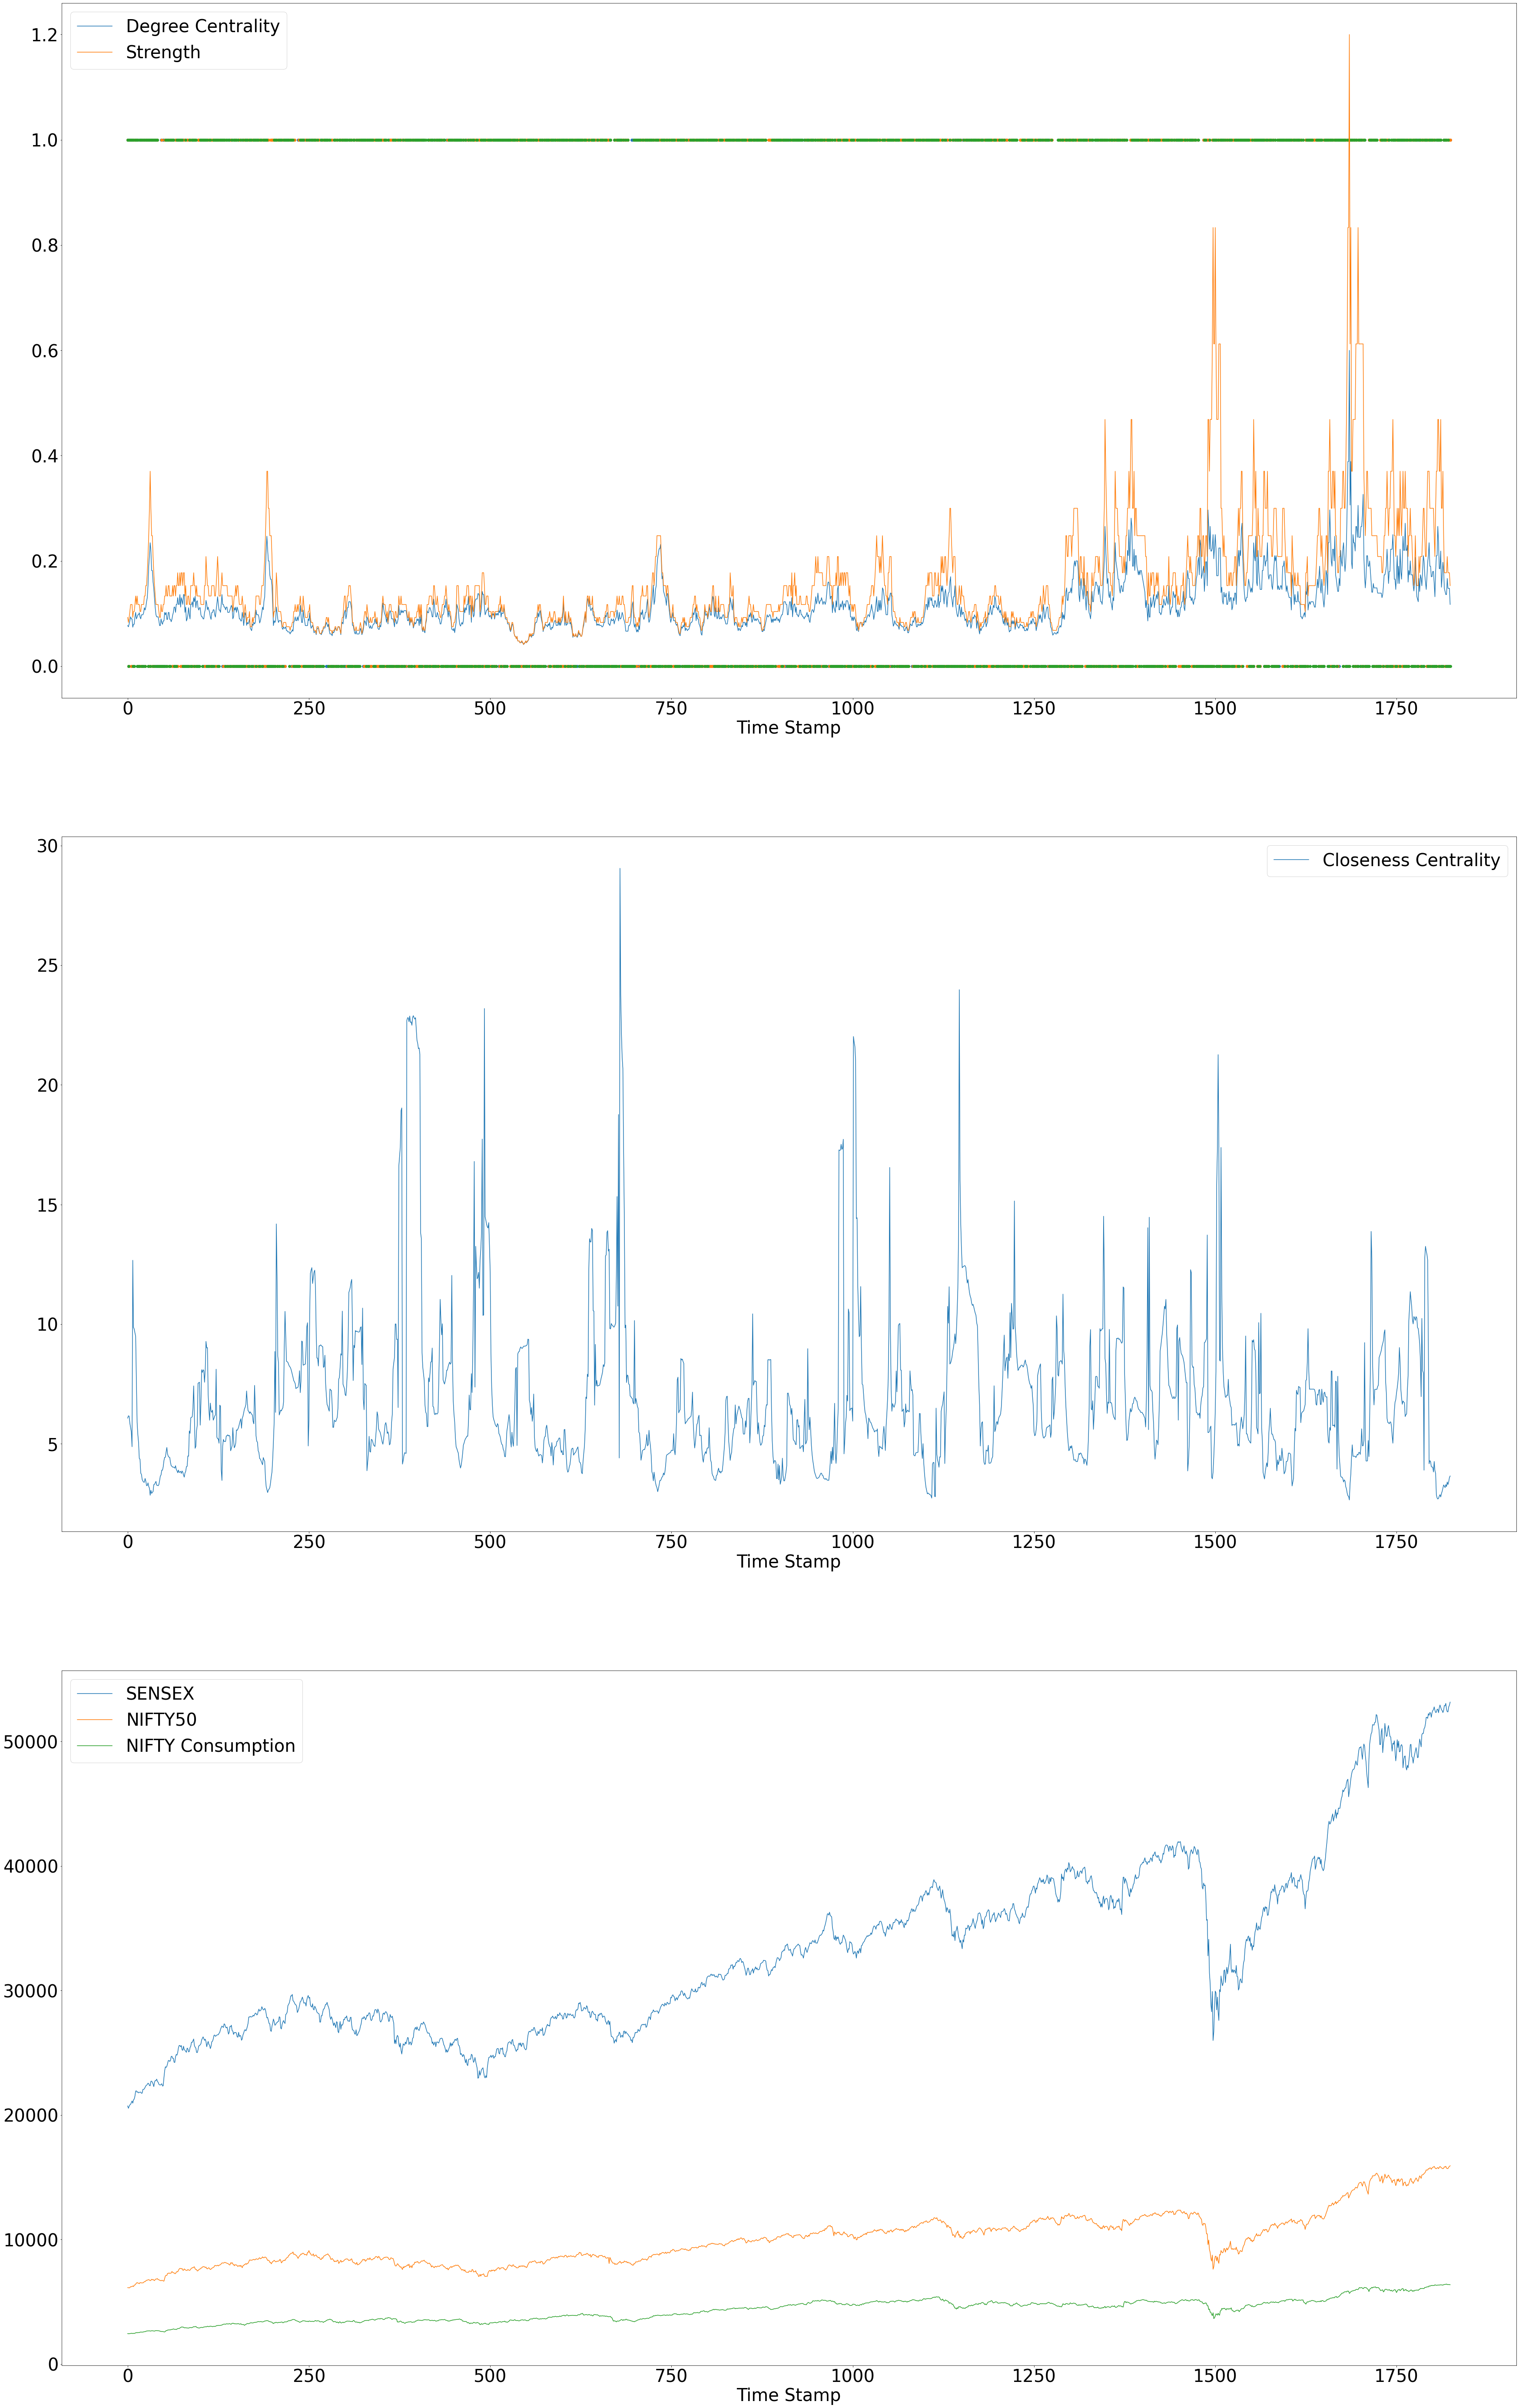

In [586]:
plt.figure(figsize=(60, 100))
plt.rcParams['font.size'] = 40
plt.subplot(3, 1, 1)

plt.plot(train_time_axis, train_avg_degree_centralities)
plt.plot(train_time_axis, train_avg_degree_strengths)
plt.scatter(train_time_axis, train_sensex_closing_target)
plt.scatter(train_time_axis, train_nifty_closing_target)
plt.scatter(train_time_axis, train_niftyc_closing_target)
plt.xlabel("Time Stamp")
plt.legend(["Degree Centrality", "Strength"])

plt.subplot(3, 1, 2)

plt.plot(train_time_axis, train_avg_closeness_centralities)
plt.xlabel("Time Stamp")
plt.legend(['Closeness Centrality'])

plt.subplot(3, 1, 3)

plt.plot(train_time_axis, train_sensex_closing_prices)
plt.plot(train_time_axis, train_nifty_closing_prices)
plt.plot(train_time_axis, train_niftyc_closing_prices)
plt.xlabel("Time Stamp")
plt.legend(['SENSEX', 'NIFTY50', 'NIFTY Consumption'])


### Classification models

#### KNN

In [604]:
train_features = train_df[['Degree Strength', 'Degree Centrality','Closeness Centrality']]
train_target1 = train_df[['SENSEX Target pattern']]
train_target2 = train_df[['NIFTY50 Target pattern']]
train_target3 = train_df[['NIFTY Consumption Target pattern']]

In [605]:
test_features = test_df[['Degree Strength', 'Degree Centrality', 'Closeness Centrality']]
test_target1 = test_df[['SENSEX Target pattern']]
test_target2 = test_df[['NIFTY50 Target pattern']]
test_target3 = test_df[['NIFTY Consumption Target pattern']]

In [561]:
knn1 = KNeighborsClassifier(n_neighbors=12)
knn2 = KNeighborsClassifier(n_neighbors=12)
knn3 = KNeighborsClassifier(n_neighbors=12)

In [562]:
knn1.fit(train_features, train_target1)
knn2.fit(train_features, train_target2)
knn3.fit(train_features, train_target3)

C:\Users\eshub\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
C:\Users\eshub\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
C:\Users\eshub\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


KNeighborsClassifier(n_neighbors=12)

In [563]:
pred1 = knn1.predict(test_features)
pred2 = knn2.predict(test_features)
pred3 = knn3.predict(test_features)

In [564]:
print(classification_report(pred1, test_target1))
print(classification_report(pred2, test_target2))
print(classification_report(pred3, test_target3))

              precision    recall  f1-score   support

           0       0.63      0.60      0.62       293
           1       0.65      0.67      0.66       315

    accuracy                           0.64       608
   macro avg       0.64      0.64      0.64       608
weighted avg       0.64      0.64      0.64       608

              precision    recall  f1-score   support

           0       0.63      0.62      0.63       277
           1       0.69      0.70      0.69       331

    accuracy                           0.66       608
   macro avg       0.66      0.66      0.66       608
weighted avg       0.66      0.66      0.66       608

              precision    recall  f1-score   support

           0       0.65      0.55      0.60       318
           1       0.58      0.67      0.62       290

    accuracy                           0.61       608
   macro avg       0.61      0.61      0.61       608
weighted avg       0.62      0.61      0.61       608



#### Logistic Regression

In [587]:
logr1 = LogisticRegression()
logr2 = LogisticRegression()
logr3 = LogisticRegression()

In [588]:
logr1.fit(train_features, train_target1)
logr2.fit(train_features, train_target2)
logr3.fit(train_features, train_target3)

C:\Users\eshub\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\eshub\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\eshub\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression()

In [589]:
predicted1 = logr1.predict(test_features)
predicted2 = logr2.predict(test_features)
predicted3 = logr3.predict(test_features)

In [590]:
print(classification_report(predicted1, test_target1))
print(classification_report(predicted2, test_target2))
print(classification_report(predicted3, test_target3))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.54      0.70       608

    accuracy                           0.54       608
   macro avg       0.50      0.27      0.35       608
weighted avg       1.00      0.54      0.70       608

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.55      0.71       608

    accuracy                           0.55       608
   macro avg       0.50      0.28      0.36       608
weighted avg       1.00      0.55      0.71       608

              precision    recall  f1-score   support

           0       0.02      0.25      0.03        20
           1       0.96      0.55      0.70       588

    accuracy                           0.54       608
   macro avg       0.49      0.40      0.37       608
weighted avg       0.92      0.54      0.67       608



C:\Users\eshub\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\eshub\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\eshub\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\eshub\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1

#### SVM

In [569]:
clf1 = SVC(kernel='poly', degree=3)
clf2 = SVC(kernel='poly', degree=3)
clf3 = SVC(kernel='poly', degree=3)

In [570]:
clf1.fit(train_features, train_target1)
clf2.fit(train_features, train_target2)
clf3.fit(train_features, train_target3)

C:\Users\eshub\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\eshub\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\eshub\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVC(kernel='poly')

In [571]:
predi1 = clf1.predict(test_features)
predi2 = clf2.predict(test_features)
predi3 = clf3.predict(test_features)

In [572]:
print(classification_report(predi1, test_target1))
print(classification_report(predi2, test_target2))
print(classification_report(predi3, test_target3))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.54      0.70       608

    accuracy                           0.54       608
   macro avg       0.50      0.27      0.35       608
weighted avg       1.00      0.54      0.70       608

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.55      0.71       608

    accuracy                           0.55       608
   macro avg       0.50      0.28      0.36       608
weighted avg       1.00      0.55      0.71       608

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.55      0.71       608

    accuracy                           0.55       608
   macro avg       0.50      0.28      0.36       608
weighted avg       1.00      0.55      0.71       608



C:\Users\eshub\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\eshub\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\eshub\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\eshub\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1

#### Decision Tree

In [610]:
dt1 = DecisionTreeClassifier()
dt2 = DecisionTreeClassifier()
dt3 = DecisionTreeClassifier()

In [611]:
dt1.fit(train_features, train_target1)
dt2.fit(train_features, train_target2)
dt3.fit(train_features, train_target3)

DecisionTreeClassifier()

In [612]:
dtpred1 = dt1.predict(test_features)
dtpred2 = dt2.predict(test_features)
dtpred3 = dt3.predict(test_features)

In [613]:
print(classification_report(dtpred1, test_target1))
print(classification_report(dtpred2, test_target2))
print(classification_report(dtpred3, test_target3))

              precision    recall  f1-score   support

           0       0.48      0.47      0.48       287
           1       0.54      0.55      0.54       321

    accuracy                           0.51       608
   macro avg       0.51      0.51      0.51       608
weighted avg       0.51      0.51      0.51       608

              precision    recall  f1-score   support

           0       0.44      0.49      0.46       251
           1       0.61      0.56      0.58       357

    accuracy                           0.53       608
   macro avg       0.52      0.52      0.52       608
weighted avg       0.54      0.53      0.53       608

              precision    recall  f1-score   support

           0       0.47      0.43      0.45       291
           1       0.52      0.56      0.54       317

    accuracy                           0.50       608
   macro avg       0.50      0.50      0.49       608
weighted avg       0.50      0.50      0.50       608



#### Multi-layer perceptron classifier

In [606]:
mlp1 = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=1)
mlp2 = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=1)
mlp3 = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=1)

In [607]:
mlp1.fit(train_features, train_target1)
mlp2.fit(train_features, train_target2)
mlp3.fit(train_features, train_target3)

C:\Users\eshub\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\eshub\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\eshub\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLPClassifier(alpha=1e-05, hidden_layer_sizes=(5, 2), random_state=1,
              solver='lbfgs')

In [608]:
nnpred1 = mlp1.predict(test_features)
nnpred2 = mlp2.predict(test_features)
nnpred3 = mlp3.predict(test_features)

In [609]:
print(classification_report(nnpred1, test_target1))
print(classification_report(nnpred2, test_target2))
print(classification_report(nnpred3, test_target3))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.54      0.70       608

    accuracy                           0.54       608
   macro avg       0.50      0.27      0.35       608
weighted avg       1.00      0.54      0.70       608

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.54      0.70       608

    accuracy                           0.54       608
   macro avg       0.50      0.27      0.35       608
weighted avg       1.00      0.54      0.70       608

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.57      0.72       608

    accuracy                           0.57       608
   macro avg       0.50      0.28      0.36       608
weighted avg       1.00      0.57      0.72       608



C:\Users\eshub\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\eshub\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\eshub\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\eshub\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1

### Naive Bayes

In [356]:
model = GaussianNB()
model.fit(train_features, train_target1)

C:\Users\eshub\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GaussianNB()

In [357]:
predictednb = model.predict(test_features)

In [358]:
print(classification_report(predictednb, test_target1))

              precision    recall  f1-score   support

           0       0.07      0.37      0.12        54
           1       0.89      0.51      0.65       556

    accuracy                           0.50       610
   macro avg       0.48      0.44      0.38       610
weighted avg       0.82      0.50      0.60       610

